## Посимвольная языковая модель.

В первом задании Вам нужно написать и обучить посимвольную нейронную языковую модель для вычисления вероятностей буквенных последовательностей (то есть слов). Такие модели используются в задачах словоизменения и распознавания/порождения звучащей речи. Для обучения модели используйте данные для русского языка из [репозитория](https://github.com/sigmorphon/conll2018/tree/master/task1/surprise).

**В процессе написания Вам нужно решить следующие проблемы:**
    
* как будет выглядеть обучающая выборка; что будет являться признаками, и что - метками классов.
* как сделать так, чтобы модель при предсказании символа учитывала все предыдущие символы слова.
* какие специальные символы нужно использовать.
* как передавать в модель текущее состояние рекуррентной сети

**Результаты:**

* предобработчик данных,
* генератор обучающих данных (батчей),
* обученная модель
* перплексия модели на настроечной выборке
* посимвольные вероятности слов в контрольной выборке

**Дополнительно:**

* дополнительный вход модели (часть речи слова, другие морфологические признаки), влияет ли его добавление на перплексию
* сравнение различных архитектур нейронной сети (FC, RNN, LSTM, QRNN, ...)

In [0]:
# it is better to do all imports at the first cell
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import torch.utils.data as utils
import time

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [6]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2019-04-07 09:53:21--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high’

russian-train-high  100%[===================>] 520.81K  --.-KB/s    in 0.06s   

2019-04-07 09:53:21 (8.24 MB/s) - ‘russian-train-high’ saved [533309/533309]

--2019-04-07 09:53:23--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [0]:
def read_dataset(infile):
    words, tags = [], []
    with open(infile, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip()
            splitted = line.split("\t")
            if len(splitted) != 3:
                continue
            words.append(splitted[0].lower())
            tags.append(splitted[2])
    return words, tags

train_words, train_tags = read_dataset("russian-train-high")
dev_words, dev_tags = read_dataset("russian-dev")
test_words, test_tags = read_dataset("russian-test")

Подумайте, какие вспомогательные токены могут быть вам полезны. Выдайте им индексы от `0` до `len(AUXILIARY) - 1`

In [0]:
AUXILIARY = {'<START>', '<END>'}

### Словарь, paddings - числовое представление всех слов, дополняем до нужной длины паддингами(числом элемента  'END')

In [0]:
class Vocabulary:
    def fit(self, data):
        """Extract unique symbols from the data, make itos (item to string) and stoi (string to index) objects"""
        symbols = set(x for elem in data for x in elem)
        self._symbols = AUXILIARY.copy()
        self._symbols.update(symbols)
        self._symbols = sorted(self._symbols)
        # Запомните следующую строчку кода - она нужна примерно всегда
        self._symbol_codes = {s: i for i, s in enumerate(self._symbols)}# символ - индекс
        self._codes_symbol = {v: k for k, v in self._symbol_codes.items()}
        # 
        self.corpus = self.transform(data)
        self.longest = max(len(i) for i in self.corpus)
        self.paddings = [[a._symbol_codes['<START>']] + i + [self._symbol_codes['<END>']]*(self.longest - len(i)+1) for i in self.corpus]
        self.longest = max(len(i) for i in self.paddings)
        return self

    def __len__(self):
        return len(self._symbols)

    def transform(self, data):
        """Transform data to indices
        Input:
            - data, list of strings
        Output:
            - list of list of char indices
        >>> self.transform(['word1', 'token2'])
        >>> [[24, 2, 19, 13, 3], [8, 2, 9, 1, 7, 4]]
        """
        for i in data:
            for j in i:
                if j not in self._symbols:
                    print("UNKNOWN SYMBOL: {}".format(j))
                    return None
        return [[self._symbol_codes[str(j)] for j in i] for i in data]
    def str_by_ind(self, v):# get words from indexes
        s = [self._codes_symbol[i.item()] for i in v]
        s = ''.join(i for i in s)
        print(s)

### Batcher

In [0]:
class Batch:
    def __init__(self, vocab):
        self.sym_ind = vocab._symbol_codes
        self.paddings = vocab.paddings
        self.longest = vocab.longest
        
    def make_batch(self, batch_size):
        '''
        inputs: capacity of batch and number of chars 
        outputs: torch tensor [batch_size x self.longest] x 2: sample and pred
        '''
        sample = torch.LongTensor(batch_size, self.longest-1)
        pred = torch.LongTensor(batch_size, self.longest-1)
        for i in range(batch_size):
            index = random.randint(0, len(self.paddings)-1)
            s = torch.Tensor(self.paddings[index])
            sample[i] = (s[:-1])
            pred[i] = (s[1:])
        sample = sample.cuda()
        pred = pred.cuda()
        return sample, pred

### Модель

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.encoder(x)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        return out, hidden
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device), torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device)

### Parameters

In [0]:
a = Vocabulary()
a.fit(train_words)# make corpus + dict symbol-code
b = Batch(a)#make batches on corpus

In [0]:
batch_size = 128
lr = 0.01
input_size = len(a)
hidden_size = 100
n_layers = 3
n_epochs = 2500
print_every = 100

In [0]:
model = Net(input_size, hidden_size, input_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss = torch.tensor(0)

In [0]:
model = Net(input_size, hidden_size, input_size, n_layers).to(device=device)
model.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/char_lang_31.dms'))

In [0]:
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/adam_char_lang_31.dms'))

### Train

In [0]:
start_time = time.clock()
losses = []
perplexity = []
for epoch in range(1, n_epochs + 1):
    
    model.zero_grad()
    loss = 0
    
    inp, target  = b.make_batch(batch_size)# take a batch of samples and targets
    hidden = model.init_hidden(batch_size)
    model.train()
    for i in range(a.longest-1):
        output, hidden = model(inp[:,i],hidden)
        loss += criterion(output.view(batch_size,-1), target[:,i])
        
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item()/a.longest)
    perplexity.append(np.exp(losses[-1]))
    
    if epoch % print_every == 0:
        print('epoch {},   \tloss {} \tperplexity {}'.format(epoch, losses[-1], perplexity[-1]))
        print('time passed %d:' %(time.clock()-start_time))

epoch 100,   	loss 0.5144882202148438 	perplexity 1.6727821865857482
time passed 8:
epoch 200,   	loss 0.46578572591145834 	perplexity 1.5932655672425389
time passed 17:
epoch 300,   	loss 0.4495382520887587 	perplexity 1.5675881877794235
time passed 26:
epoch 400,   	loss 0.4296836853027344 	perplexity 1.5367713432971342
time passed 35:
epoch 500,   	loss 0.4019052293565538 	perplexity 1.4946696751568074
time passed 44:
epoch 600,   	loss 0.39642901950412324 	perplexity 1.486506921231625
time passed 52:
epoch 700,   	loss 0.3772795783148872 	perplexity 1.458311964784458
time passed 61:
epoch 800,   	loss 0.3683821784125434 	perplexity 1.4453943319412126
time passed 70:
epoch 900,   	loss 0.36214273240831163 	perplexity 1.436403948724359
time passed 79:
epoch 1000,   	loss 0.3599880218505859 	perplexity 1.4333122460292769
time passed 88:
epoch 1100,   	loss 0.3440824932522244 	perplexity 1.410695003526562
time passed 97:
epoch 1200,   	loss 0.3323418935139974 	perplexity 1.394229445039

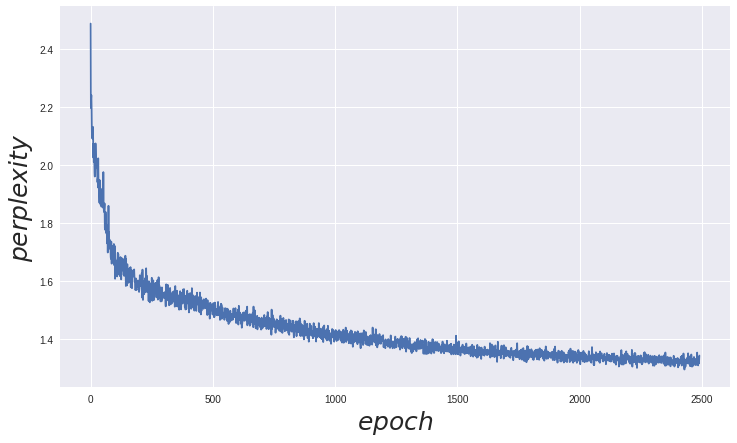

In [0]:
plt.figure(figsize=(12,7))
plt.plot(range(len(perplexity[10:])), perplexity[10:])
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$perplexity$", fontsize=25)
plt.show()

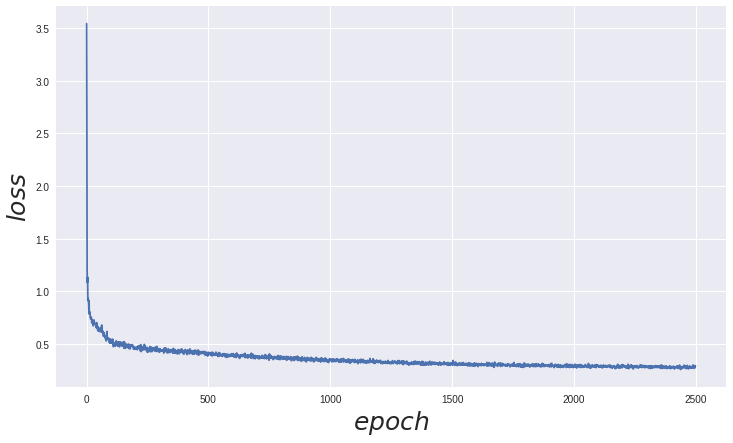

In [0]:
plt.figure(figsize=(12,7))
plt.plot(range(len(losses)), losses)
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$loss$", fontsize=25)
plt.show()

 ## Получаем вероятности букв, сначала на обучающей и тестовых выборках проверим качество предсказания слов(выводим последовательность символов, для которых вероятность максимальная)

In [0]:
def print_examples(vocab, number, inpu, outp):
    for i in range(number):
        print(vocab.str_by_ind(inpu[i]))
        pred = []
        for j in range(vocab.longest-1):
            pred.append(func.softmax(outp[j][i] ,dim = 0))
        res = torch.zeros(vocab.longest-1)
        for s in range(vocab.longest-1):
            _, m = torch.max(pred[s],0)
            res[s] = m
        print(vocab.str_by_ind(res))
    return pred

In [0]:
def make_prediction():
    probs = []
    o = []
    with torch.no_grad():
        inp, target  = b.make_batch(batch_size)
        hid = model.init_hidden(batch_size)
        for i in range(a.longest-1):
            output, hid = model(inp[:,i],hid)
            o.append(output)
    return inp, target, o

In [22]:
inpu, targ, outp = make_prediction()
_ = print_examples(a, 7, inpu, outp)

<START>проезжий<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
прискднй<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
<START>отмель<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
птсоньн<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
<START>встроенный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
пыероинный<END><END>

In [0]:
tes = Vocabulary()
tes.fit(test_words)# make corpus + dict symbol-code
b_tes = Batch(tes)#make batches on corpus

In [0]:
def make_test_prediction():
    probs = []
    o = []
    with torch.no_grad():
        inp, target  = b_tes.make_batch(batch_size)
        hid = model.init_hidden(batch_size)
        for i in range(tes.longest-1):
            output, hid = model(inp[:,i],hid)
            o.append(output)
    return inp, target, o

Видно, что на тесте получается довольно-таки бессмысленный набор букв иногда, но этого достаточно чтобы понять какая например это была часть речи(окончание слова хорошо восстанавливается)

In [25]:
inpu, targ, outp = make_test_prediction()
s = print_examples(tes, 7, inpu, outp)

<START>аброгация<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
пноесн<END>ио<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
<START>ссылаться<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
птулать<END>я<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
<START>оптимальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
птоомальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
<START>хрустальный<END><END><END><END><END

## Получаем вероятности последовательность букв на тестовой выборке (по заданию)

In [0]:
def get_prob(vocab, word, outp):
    word_num = [vocab._symbol_codes[i] for i in word]
    probability = 1.0
    for i in word_num:
        probs = func.softmax(outp[i][0], dim = 0)
        probability *= probs[i].item()
    return probability

Возьмем для примера слово 'оптимальный'

In [65]:
'''
<START>оптимальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
птоомальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>
None
'''

'\n<START>оптимальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>\nNone\nптоомальный<END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END><END>\nNone\n'

In [55]:
kek = []# вероятности всех символов для слова оптимальный
for i in range(len(outp)):
    kek.append(func.softmax(outp[i][2] ,dim = 0))
for i in range(len(kek)):# выведем максимальные для каждой позиции в восстановленной последовательности
    m, index = torch.max(kek[i], 0)
    print('{}\t {}\t {} '.format(i , m.item() , tes._codes_symbol[index.item()]))

0	 0.1772516965866089	 п 
1	 0.28403031826019287	 т 
2	 0.19231997430324554	 о 
3	 0.595186173915863	 о 
4	 0.6338268518447876	 м 
5	 0.9856933355331421	 а 
6	 0.7763628959655762	 л 
7	 0.9807737469673157	 ь 
8	 0.9235853552818298	 н 
9	 0.9726911187171936	 ы 
10	 0.9999760389328003	 й 
11	 0.9928141236305237	 <END> 
12	 0.9999954700469971	 <END> 
13	 0.9999994039535522	 <END> 
14	 0.9999997615814209	 <END> 
15	 0.9999998807907104	 <END> 
16	 0.9999998807907104	 <END> 
17	 1.0	 <END> 
18	 1.0	 <END> 
19	 1.0	 <END> 
20	 1.0	 <END> 
21	 1.0	 <END> 
22	 1.0	 <END> 
23	 1.0	 <END> 
24	 1.0	 <END> 
25	 1.0	 <END> 
26	 1.0	 <END> 
27	 1.0	 <END> 
28	 1.0	 <END> 
29	 1.0	 <END> 
30	 1.0	 <END> 
31	 1.0	 <END> 
32	 1.0	 <END> 
33	 1.0	 <END> 
34	 1.0	 <END> 
35	 1.0	 <END> 
36	 1.0	 <END> 
37	 1.0	 <END> 


In [57]:
for i in range(len(tes)):# вероятности для первого символа в последовательности
  print('{}\t {}\t {} '.format(i , kek[0][i].item() , tes._codes_symbol[i]))

0	 3.256546187913045e-05	   
1	 7.068877039273502e-06	 - 
2	 0.00016565762052778155	 <END> 
3	 9.741504072735552e-06	 <START> 
4	 0.041089121252298355	 а 
5	 0.03406422212719917	 б 
6	 0.07048953324556351	 в 
7	 0.02953595668077469	 г 
8	 0.03046807460486889	 д 
9	 0.0025457278825342655	 е 
10	 0.007939429953694344	 ж 
11	 0.049185577780008316	 з 
12	 0.031372033059597015	 и 
13	 0.0004263230657670647	 й 
14	 0.062392279505729675	 к 
15	 0.01598728448152542	 л 
16	 0.04148672893643379	 м 
17	 0.054625093936920166	 н 
18	 0.06692806631326675	 о 
19	 0.1772516965866089	 п 
20	 0.04649420455098152	 р 
21	 0.09827367961406708	 с 
22	 0.04264147952198982	 т 
23	 0.033024583011865616	 у 
24	 0.008134462870657444	 ф 
25	 0.011009804904460907	 х 
26	 0.006646375637501478	 ц 
27	 0.010203097015619278	 ч 
28	 0.0092851547524333	 ш 
29	 0.0018333970801904798	 щ 
30	 2.5059218387468718e-05	 ъ 
31	 7.798523438395932e-05	 ы 
32	 6.757202936569229e-05	 ь 
33	 0.010913899168372154	 э 
34	 0.0021022837

Вероятность слова, который выдал модель/вероятность правильного слова

In [63]:
prob = 1.0
for i in range(len(kek)):# для восстановленного слова ()
    m, _ = torch.max(kek[i], 0)
    prob *= m.item()
print(prob)

0.002445037256052218


In [77]:
prob = 1.0
for i in range(len(inpu[2])):# для настоящего слова ()
    s = inpu[2][i].item()
    pred = func.softmax(outp[i][2] ,dim = 0)
    prob *= pred[s].item()
print(prob)

8.5343036845039e-55
